# Project 1: Heart Attack Prediction

This notebook implements a machine learning pipeline to predict the risk of heart disease based on the BRFSS dataset[cite: 31, 104]. The objective is to implement, tune, and evaluate several fundamental machine learning models from scratch, as outlined in the project description[cite: 10, 38].

The workflow is as follows:
1.  **Setup and Imports**: Load necessary libraries.
2.  **Core Implementations**: Define all required ML models and helper functions.
3.  **Data Preprocessing**: Clean and prepare the data for training, mirroring the successful approach of undersampling, median imputation, and standardization.
4.  **Hyperparameter Tuning & Evaluation**: For each required model, we will:
    a. Tune its key hyperparameters and visualize the impact on model loss.
    b. Train the model using the optimal hyperparameter.
    c. Evaluate its performance using Accuracy and F1-score on both balanced and imbalanced data.
5.  **Final Submission**: Select the best model and generate the prediction file.

## 1. Setup and Imports

We use `NumPy` for numerical computations and `Matplotlib` for plotting.

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

## 2. Core ML & Helper Functions

This section contains the implementations of the six required machine learning algorithms and all necessary helper functions for data loading, evaluation metrics, and preprocessing.

In [2]:
# --- Data Loading ---
def load_csv_data(data_path, data_type='train'):
    """Loads data and returns y, tx, and ids."""
    if data_type == 'train':
        y = np.genfromtxt(f"{data_path}/y_train.csv", delimiter=",", skip_header=1, dtype=int, usecols=1)
        x = np.genfromtxt(f"{data_path}/x_train.csv", delimiter=",", skip_header=1)
        ids = x[:, 0].astype(int)
        tx = x[:, 2:]
        return y, tx, ids
    elif data_type == 'test':
        x = np.genfromtxt(f"{data_path}/x_test.csv", delimiter=",", skip_header=1)
        ids = x[:, 0].astype(int)
        tx = x[:, 2:]
        return None, tx, ids

# --- Submission ---
def create_csv_submission(ids, y_pred, name):
    """Creates a submission file in csv format."""
    with open(name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Id', 'Prediction'])
        for i, pred in zip(ids, y_pred):
            writer.writerow([i, int(pred)])

# --- Utility & Math Functions ---
def sigmoid(t):
    t = np.clip(t, -500, 500)
    return 1.0 / (1.0 + np.exp(-t))

# --- Loss & Gradient Functions ---
def compute_mse_loss(y, tx, w):
    e = y - tx.dot(w)
    return 1 / 2 * np.mean(e**2)

def compute_logistic_loss(y, tx, w):
    pred = sigmoid(tx.dot(w))
    epsilon = 1e-12
    pred = np.clip(pred, epsilon, 1 - epsilon)
    loss = -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))
    return loss

def compute_logistic_gradient(y, tx, w):
    pred = sigmoid(tx.dot(w))
    return tx.T.dot(pred - y) / len(y)

# --- Required ML Implementations ---
def least_squares(y, tx):
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    loss = compute_mse_loss(y, tx, w)
    return w, loss

def ridge_regression(y, tx, lambda_):
    N, D = tx.shape
    a = tx.T.dot(tx) + 2 * N * lambda_ * np.identity(D)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    loss = compute_mse_loss(y, tx, w)
    return w, loss

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for _ in range(max_iters):
        gradient = compute_logistic_gradient(y, tx, w)
        w = w - gamma * gradient
    loss = compute_logistic_loss(y, tx, w)
    return w, loss

def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    w = initial_w
    losses = []
    for _ in range(max_iters):
        gradient = compute_logistic_gradient(y, tx, w) + 2 * lambda_ * w
        w = w - gamma * gradient
    loss = compute_logistic_loss(y, tx, w)
    return w, loss

# --- Evaluation Metrics ---
def predict_labels(w, tx, threshold=0.5, is_logistic=True):
    if is_logistic:
        probs = sigmoid(tx.dot(w))
        return np.where(probs > threshold, 1, -1)
    else: # For linear regression models
        preds = tx.dot(w)
        return np.where(preds > threshold, 1, -1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

## 3. Data Loading and Preprocessing

First, we load the data. A key observation is the severe class imbalance, which we must address. The preprocessing pipeline will perform the following steps in order:
1.  **Undersampling**: To balance the dataset for more effective training[cite: 206].
2.  **Median Imputation**: To handle missing values (`-999`) in a way that is robust to outliers[cite: 202].
3.  **Standardization (Z-score)**: To scale features to have zero mean and unit variance, which helps gradient-based optimization[cite: 211].
4.  **Polynomial Feature Expansion**: To allow the linear models to capture non-linear patterns[cite: 213].
5.  **Add Bias Term**: To add an intercept to the models.

In [3]:
def preprocess_data(x_train, y_train, x_test):
    """Preprocesses the data using undersampling, median imputation, standardization, and polynomial expansion."""
    # Replace -999 with NaN for easier calculations
    x_train[x_train == -999] = np.nan
    x_test[x_test == -999] = np.nan

    # 1. Undersample the majority class
    np.random.seed(42)
    majority_indices = np.where(y_train == -1)[0]
    minority_indices = np.where(y_train == 1)[0]
    undersample_indices = np.random.choice(majority_indices, size=len(minority_indices), replace=False)
    balanced_indices = np.concatenate([minority_indices, undersample_indices])
    np.random.shuffle(balanced_indices)
    x_train_balanced = x_train[balanced_indices]
    y_train_balanced = y_train[balanced_indices]

    # 2. Impute missing values with median from the *original* training set
    train_medians = np.nanmedian(x_train, axis=0)
    x_train_balanced[np.isnan(x_train_balanced)] = np.take(train_medians, np.where(np.isnan(x_train_balanced))[1])
    x_test[np.isnan(x_test)] = np.take(train_medians, np.where(np.isnan(x_test))[1])
    x_train_imbalanced_clean = np.copy(x_train)
    x_train_imbalanced_clean[np.isnan(x_train_imbalanced_clean)] = np.take(train_medians, np.where(np.isnan(x_train_imbalanced_clean))[1])

    # 3. Standardize features based on the *balanced* training set
    mean = np.mean(x_train_balanced, axis=0)
    std = np.std(x_train_balanced, axis=0)
    std[std == 0] = 1 # Avoid division by zero
    x_train_std = (x_train_balanced - mean) / std
    x_test_std = (x_test - mean) / std
    x_train_imbalanced_std = (x_train_imbalanced_clean - mean) / std

    # 4. Polynomial expansion (degree 2)
    degree = 2
    x_train_poly = np.hstack([x_train_std, x_train_std**degree])
    x_test_poly = np.hstack([x_test_std, x_test_std**degree])
    x_train_imbalanced_poly = np.hstack([x_train_imbalanced_std, x_train_imbalanced_std**degree])

    # 5. Add bias column
    tx_train_balanced = np.hstack([np.ones((x_train_poly.shape[0], 1)), x_train_poly])
    tx_test = np.hstack([np.ones((x_test_poly.shape[0], 1)), x_test_poly])
    tx_train_imbalanced = np.hstack([np.ones((x_train_imbalanced_poly.shape[0], 1)), x_train_imbalanced_poly])

    return tx_train_balanced, y_train_balanced, tx_test, tx_train_imbalanced

# --- Load and Preprocess Data ---
DATA_PATH = "./data/"
y_train_orig, x_train_orig, _ = load_csv_data(DATA_PATH, 'train')
_, x_test_orig, test_ids = load_csv_data(DATA_PATH, 'test')

tx_train_b, y_train_b, tx_test, tx_train_imb = preprocess_data(x_train_orig, y_train_orig, x_test_orig)

# Convert labels to {0, 1} for logistic models
y_train_b_logistic = np.where(y_train_b == -1, 0, 1)

print(f"Shape of balanced training data: {tx_train_b.shape}")
print(f"Shape of imbalanced validation data: {tx_train_imb.shape}")
print(f"Shape of test data: {tx_test.shape}")

Shape of balanced training data: (57950, 641)
Shape of imbalanced validation data: (328135, 641)
Shape of test data: (109379, 641)


## 4. Model Training, Tuning, and Evaluation

We now proceed to tune and evaluate each of the required models.

### 4.1 Ridge Regression

We first tune the regularization parameter `lambda` for Ridge Regression. We search over a logarithmic scale of values and plot the resulting MSE loss to find the optimal value.

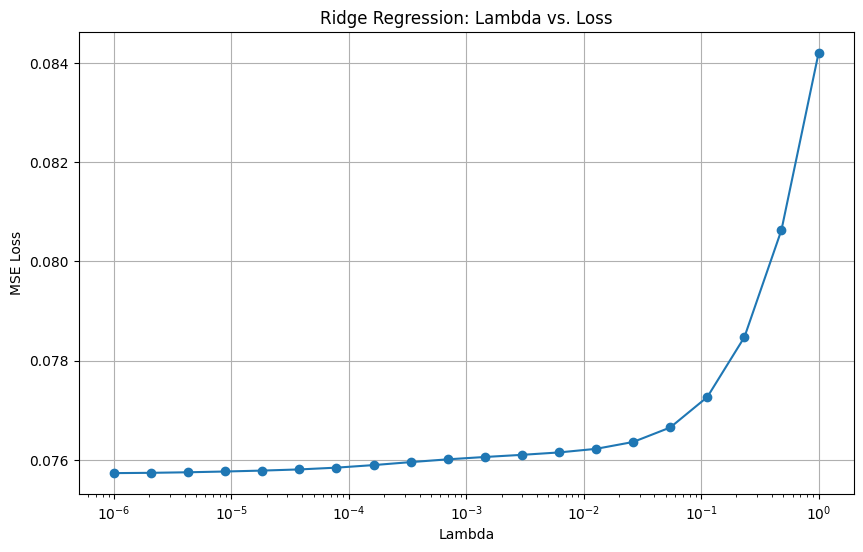

Best lambda for Ridge Regression: 1e-06


In [5]:
# Tune lambda for Ridge Regression
lambdas = np.logspace(-6, 0, 20)
losses = []
for lambda_ in lambdas:
    _, loss = ridge_regression(y_train_b_logistic, tx_train_b, lambda_)
    losses.append(loss)

best_lambda_ridge = lambdas[np.argmin(losses)]

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, losses, marker='o')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')
plt.title('Ridge Regression: Lambda vs. Loss')
plt.grid(True)

plt.show()

print(f"Best lambda for Ridge Regression: {best_lambda_ridge}")

In [6]:
# Train and evaluate Ridge Regression with the best lambda
w_ridge, _ = ridge_regression(y_train_b_logistic, tx_train_b, best_lambda_ridge)

# Predictions (using 0.5 as threshold since y is {0, 1})
y_pred_b = predict_labels(w_ridge, tx_train_b, threshold=0.5, is_logistic=False)
y_pred_imb = predict_labels(w_ridge, tx_train_imb, threshold=0.5, is_logistic=False)

print("--- Ridge Regression Evaluation ---")
print(f"Balanced Training Set -> Accuracy: {accuracy(y_train_b, y_pred_b):.4f}, F1-score: {f1_score(y_train_b, y_pred_b):.4f}")
print(f"Imbalanced Validation Set -> Accuracy: {accuracy(y_train_orig, y_pred_imb):.4f}, F1-score: {f1_score(y_train_orig, y_pred_imb):.4f}")

--- Ridge Regression Evaluation ---
Balanced Training Set -> Accuracy: 0.7882, F1-score: 0.7934
Imbalanced Validation Set -> Accuracy: 0.7622, F1-score: 0.3767


### 4.2 Logistic Regression

Next, we tune the learning rate `gamma` for standard Logistic Regression.

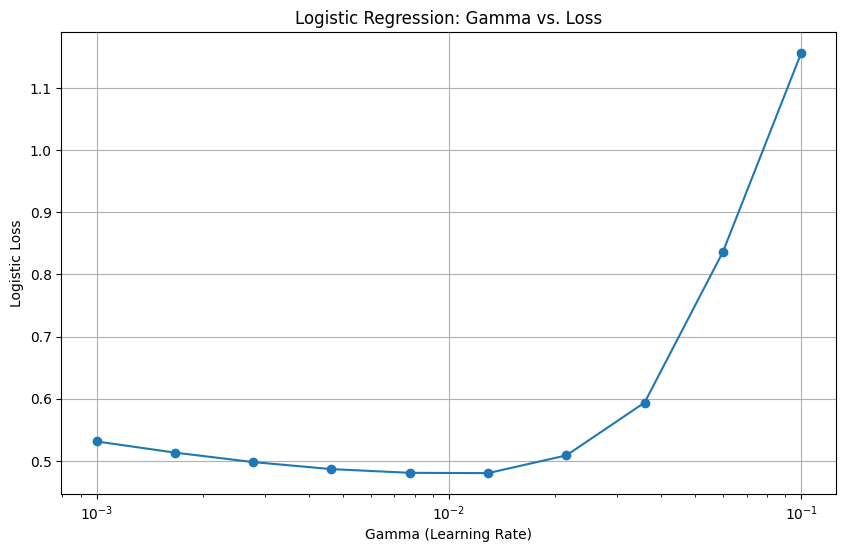

Best gamma for Logistic Regression: 0.01291549665014884


In [7]:
# Tune gamma for Logistic Regression
gammas = np.logspace(-3, -1, 10)
losses_lr = []
initial_w_lr = np.zeros(tx_train_b.shape[1])

for gamma in gammas:
    _, loss = logistic_regression(y_train_b_logistic, tx_train_b, initial_w_lr, max_iters=500, gamma=gamma)
    losses_lr.append(loss)

best_gamma_lr = gammas[np.argmin(losses_lr)]

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(gammas, losses_lr, marker='o')
plt.xlabel('Gamma (Learning Rate)')
plt.ylabel('Logistic Loss')
plt.title('Logistic Regression: Gamma vs. Loss')
plt.grid(True)

plt.show()

print(f"Best gamma for Logistic Regression: {best_gamma_lr}")

In [8]:
# Train and evaluate Logistic Regression with the best gamma
w_lr, _ = logistic_regression(y_train_b_logistic, tx_train_b, initial_w_lr, max_iters=5000, gamma=best_gamma_lr)

# Predictions
y_pred_b_lr = predict_labels(w_lr, tx_train_b)
y_pred_imb_lr = predict_labels(w_lr, tx_train_imb)

print("--- Logistic Regression Evaluation ---")
print(f"Balanced Training Set -> Accuracy: {accuracy(y_train_b, y_pred_b_lr):.4f}, F1-score: {f1_score(y_train_b, y_pred_b_lr):.4f}")
print(f"Imbalanced Validation Set -> Accuracy: {accuracy(y_train_orig, y_pred_imb_lr):.4f}, F1-score: {f1_score(y_train_orig, y_pred_imb_lr):.4f}")

--- Logistic Regression Evaluation ---
Balanced Training Set -> Accuracy: 0.7850, F1-score: 0.7872
Imbalanced Validation Set -> Accuracy: 0.7711, F1-score: 0.3804


### 4.3 Regularized Logistic Regression

For this model, we need to tune both `lambda` and `gamma`. We perform a simple grid search to find the best combination.

In [ ]:
# Tune lambda and gamma for Regularized Logistic Regression
lambdas_reg = np.logspace(-6, -2, 5)
gammas_reg = np.logspace(-3, -1, 5)
best_loss_reg = float('inf')
best_params = {'lambda': None, 'gamma': None}
initial_w_reg = np.zeros(tx_train_b.shape[1])

print("Starting grid search for Regularized Logistic Regression...")
for lambda_ in lambdas_reg:
    for gamma in gammas_reg:
        _, loss = reg_logistic_regression(y_train_b_logistic, tx_train_b, lambda_, initial_w_reg, max_iters=500, gamma=gamma)
        if loss < best_loss_reg:
            best_loss_reg = loss
            best_params['lambda'] = lambda_
            best_params['gamma'] = gamma

print(f"Grid search complete. Best parameters: {best_params}")

In [ ]:
# Train and evaluate Regularized Logistic Regression with best params
best_lambda_reg = best_params['lambda']
best_gamma_reg = best_params['gamma']

# Train final model for more iterations
w_reg, final_loss_reg = reg_logistic_regression(y_train_b_logistic, tx_train_b, best_lambda_reg, initial_w_reg, max_iters=5000, gamma=best_gamma_reg)

# Predictions
y_pred_b_reg = predict_labels(w_reg, tx_train_b)
y_pred_imb_reg = predict_labels(w_reg, tx_train_imb)

print(f"\n--- Regularized Logistic Regression Evaluation (Loss: {final_loss_reg:.4f}) ---")
print(f"Balanced Training Set -> Accuracy: {accuracy(y_train_b, y_pred_b_reg):.4f}, F1-score: {f1_score(y_train_b, y_pred_b_reg):.4f}")
print(f"Imbalanced Validation Set -> Accuracy: {accuracy(y_train_orig, y_pred_imb_reg):.4f}, F1-score: {f1_score(y_train_orig, y_pred_imb_reg):.4f}")

## 5. Final Model Selection and Submission

As a final optimization on the Regularized Logistic Regression, we will tune the prediction threshold on the imbalanced validation set to maximize the F1-score.

In [ ]:
# Tune the prediction threshold for the best model (w_reg)
best_f1_tuned = 0
best_threshold_tuned = 0.5
y_probs_val = sigmoid(tx_train_imb.dot(w_reg))

for threshold in np.linspace(0, 1, 101):
    y_pred_val = np.where(y_probs_val > threshold, 1, -1)
    current_f1 = f1_score(y_train_orig, y_pred_val)
    if current_f1 > best_f1_tuned:
        best_f1_tuned = current_f1
        best_threshold_tuned = threshold

print(f"Best threshold found: {best_threshold_tuned:.2f} with an F1-score of {best_f1_tuned:.4f}")

In [ ]:
# Generate final predictions on the test set
y_pred_test = predict_labels(w_reg, tx_test, threshold=best_threshold_tuned)

# Create submission file
submission_file = 'submission.csv'
create_csv_submission(test_ids, y_pred_test, submission_file)
print(f"\nSubmission file '{submission_file}' has been generated.")